# MCMC for Linear regression with normal distribution

In [1]:
# import libraries
import jax
import jax.numpy as jnp
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
try:
    import blackjax
except:
    %pip install -qq blackjax
    import blackjax
import matplotlib.pyplot as plt
import pickle
import logging
from rmh import rmh_inference_loop,plot_rmh
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())
key = jax.random.PRNGKey(5)

2022-06-13 16:00:54.805705: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


Lets generate samples now.

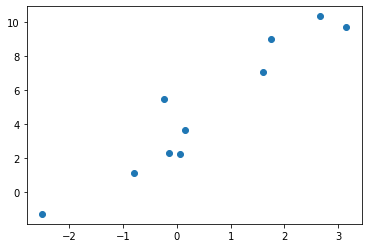

In [2]:
with open("../data/linear_regression/linear_regression",'rb') as f:
    data = pickle.load(f)
x = jnp.array(data['data']['x'])
def identity_trans(x):
    return jnp.append(jnp.ones((m,1)),x,axis=1)
m = x.shape[0]
x_trans = identity_trans(x)
y = jnp.array(data['data']['y'])
prior_mean = jnp.array(data['prior']['mean'])
prior_var = jnp.array(data['prior']['var'])
noise_var = data['noise_variance']
prior_alpha, prior_beta = data['prior']['alpha'],data['prior']['beta']
plt.scatter(x,y)

In [3]:
def create_log_postfn(x_trans,y,prior_mean,prior_var,prior_alpha,prior_beta):
  n = x_trans.shape[1]
  prior_normal = tfd.MultivariateNormalFullCovariance(
      loc = prior_mean,covariance_matrix= prior_var
  )
  prior_noise = tfd.InverseGamma(prior_alpha,prior_beta)
  y = y.reshape(m,)
  def log_postfn(params):
    # from the above equation
    # log_prior = -(x/lamda)**k+ (k-1)*(jnp.log(x)-jnp.log(lamda)) +jnp.log(k/lamda)
    noise_var = params['noise_var']
    theta = params['theta']
    
    log_prior_noise = prior_noise.log_prob(noise_var)
    log_prior = prior_normal.log_prob(theta)
    # log_likelihood
    mean = (x_trans@theta.reshape(n,1)).reshape(m,)
    likelihood_normal = tfd.MultivariateNormalFullCovariance(mean,noise_var*jnp.identity(m))
    log_like = jnp.array(likelihood_normal.log_prob(y))
    return (log_like+log_prior+log_prior_noise)
  return log_postfn
log_postfn = create_log_postfn(x_trans,y,prior_mean,prior_var,prior_alpha,prior_beta)

RMH here stands for Random walk Metropolis Hastings.
We will use the blackjax implementation of it.

Things we have to do using jax


*   rmh takes the log of posterior pdf and sigma is the walk length parameter. So give them.
*   Then define the initial state of the rmh. This is done by just giving the initial value of whatever we are trying to estimate.




In [4]:

initial = {"theta":prior_mean,"noise_var":6.0}
log_postfn(initial)

DeviceArray(-229.90926, dtype=float32)

In [5]:
n = x_trans.shape[1]+1
states = rmh_inference_loop(log_postfn,jnp.identity(n) * 0.7,initial,10000)

Lets generate samples from posterior distribution now.

lets now see how it is varying. As we can see from the below figure, the parameter is changing a lot durin the first 300 iterations and then having a stationary distribution. So we eliminate the first 300 samples and then just take a target distribution as the emperical distribution of the samples.

In [6]:
jnp.ndim(states.position['theta'])

2

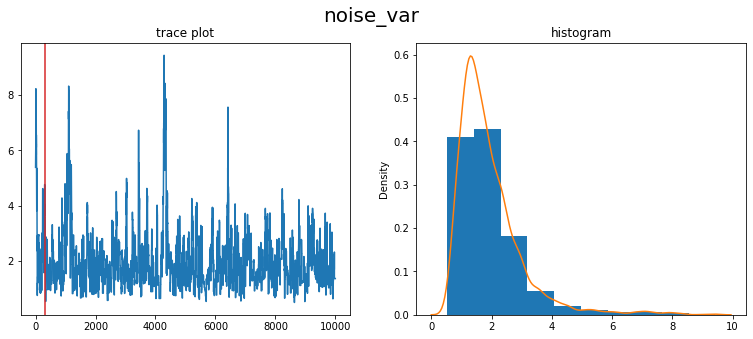

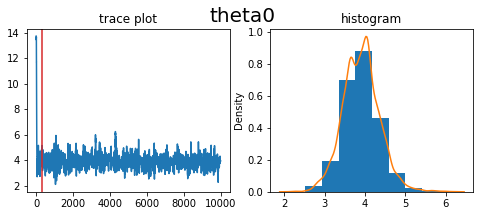

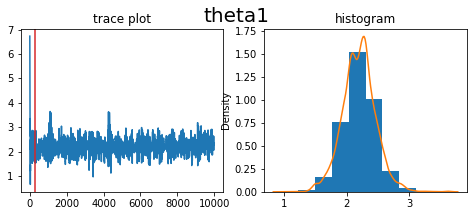

In [7]:
burnin = 300
states_theta = states
states_var = states
# del states_var.position['theta']
plot_rmh(states,burnin,contains_arrays=False)

In [46]:
burnin = 300
states_theta = states
states_var = states
del states_theta.position['noise_var']
plot_rmh(states_theta,burnin,contains_arrays=False)

In [28]:
plot_rmh(states_var,burnin)

In [10]:
from pandas import to_pickle
to_pickle(states,"../results/linear_regression/results_data/MCMC_Blackjax")

Now lets see how well the samples are fitting our initial data.

I will just compare with the actual pdf.

<h1> So I am happy :)</h1>